### Introduction

This notebook demonstrates the application of linear regression to the
[Boston Housing dataset](https://www.kaggle.com/datasets/vikrishnan/boston-house-prices/data), a classic benchmark for supervised learning in
regression tasks. Although the model consists of a single linear layer,
the training pipeline incorporates core techniques used in modern
machine learning systems, including minibatch stochastic gradient
descent and gradient-based optimization.

By focusing on a simple model, this project highlights the fundamentals
of model training, loss minimization, and evaluation that underpin more
complex neural network architectures.

This notebook builds on concepts from Zhang et al., [*Dive into Deep Learning*](https://d2l.ai/index.html), particularly abstractions for data loading and training loops.
All such components have been **adapted and customized** to illustrate their use in a linear regression context. The model, dataset processing, and analysis were implemented independently. Abstractions can be
referenced in `../abstractions/torch.py`.
### Dataset

The Boston Housing dataset contains socioeconomic and geographic features
describing neighborhoods in Boston, with the target variable being the
median value of owner-occupied homes.

#### EDA

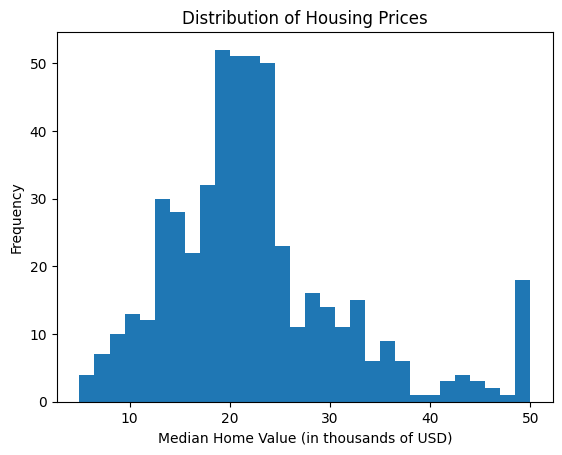

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd

file_path = os.path.join("data", "housing.csv")
data = pd.read_csv(file_path, sep=r"\s+", header=None)

y = data.iloc[:, -1].values

plt.figure()
plt.hist(y, bins=30)
plt.xlabel("Median Home Value (in thousands of USD)")
plt.ylabel("Frequency")
plt.title("Distribution of Housing Prices")
plt.show()

The distribution of housing prices is right-skewed, indicating the
presence of higher-value outliers that may influence regression error.

Below are the feature mappings of the dataset.

| Index | Feature | Description                                                           |
|-------|---------|-----------------------------------------------------------------------|
| 0     | CRIM    | Per capita crime rate by town                                         |
| 1     | ZN      | Proportion of residential land zoned for lots > 25,000 sq.ft.         |
| 2     | INDUS   | Proportion of non-retail business acres per town                      |
| 3     | CHAS    | Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) |
| 4     | NOX     | Nitric oxides concentration (parts per 10 million)                    |
| 5     | RM      | Average number of rooms per dwelling                                  |
| 6     | AGE     | Proportion of owner-occupied units built prior to 1940                |
| 7     | DIS     | Weighted distances to five Boston employment centers                  |
| 8     | RAD     | Index of accessibility to radial highways                             |
| 9     | TAX     | Full-value property-tax rate per $10,000                              |
| 10    | PTRATIO | Pupil-teacher ratio by town                                           |
| 11    | B       | 1000(Bk − 0.63)^2 where Bk is proportion of blacks by town            |
| 12    | LSTAT   | % lower status of the population                                      |
| 13    | MEDV    | Median value of owner-occupied homes in thousands of USD (target)     |

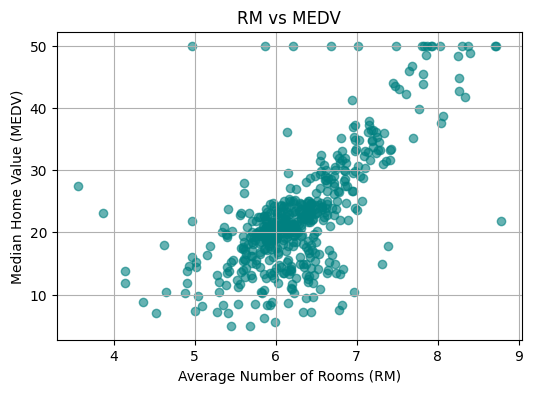

In [2]:
X = data.iloc[:, 5].values  # RM
y = data.iloc[:, -1].values  # MEDV

plt.figure(figsize=(6,4))
plt.scatter(X, y, alpha=0.6, color='teal')
plt.xlabel("Average Number of Rooms (RM)")
plt.ylabel("Median Home Value (MEDV)")
plt.title("RM vs MEDV")
plt.grid(True)
plt.show()

There is a clear positive relationship between the average number of
rooms and median home value, supporting the use of linear regression
as a baseline model.

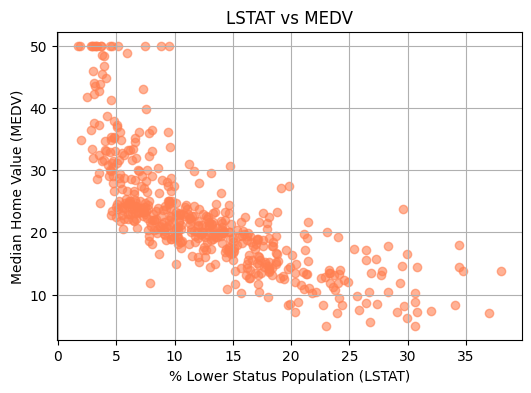

In [3]:
X = data.iloc[:, 12].values  # LSTAT

plt.figure(figsize=(6,4))
plt.scatter(X, y, alpha=0.6, color='coral')
plt.xlabel("% Lower Status Population (LSTAT)")
plt.ylabel("Median Home Value (MEDV)")
plt.title("LSTAT vs MEDV")
plt.grid(True)
plt.show()

A higher proportion of lower-status population is associated with
lower housing prices, indicating a negative linear trend with MEDV.

## Linear Regression Implementation

We will implement a linear regression model that fits a hyperplane to the data by learning weights $ w_1, \dots, w_{13} $ and bias $b$ that minimize the mean squared error of the following:
$$
f(\vec{x}) = \vec{w} \cdot \vec{x} + b
$$

### Data

We first start by creating a model for our data. It is worth mentioning that feature columns have been normalized with $μ = 0$ and $σ = 1$ to hedge against spikes in our gradient-based optimization. Furthermore, we define a method `get_dataloader` that accepts a boolean `train` to partition our dataset into a training and validation set. The original Boston Housing dataset has 506 columns, and we have chosen to train our model on 400 examples, and leave the other 106 for validation.

In [4]:
from d2l import torch as d2l
import torch

class BostonHouseData(d2l.DataModule):
    def __init__(self, batch_size):
        super().__init__()
        self.save_hyperparameters()

        file_path = os.path.join("data", "housing.csv")
        data = pd.read_csv(file_path, sep=r"\s+", header=None)

        X = data.iloc[:, :-1].values
        X = (X - X.mean(axis=0)) / X.std(axis=0)

        self.X = torch.tensor(X, dtype=torch.float)
        self.y = torch.tensor(data.iloc[:, -1].values, dtype=torch.float).reshape(-1,1)
        self.num_train_examples = 400

    def get_dataloader(self, train):
        i = slice(0, self.num_train_examples) if train else slice(self.num_train_examples, None)
        return self.get_tensorloader((self.X, self.y), train, i)


### Model

Here we declare our model. Our model initializes our weights, $\vec{w}$, based on PyTorch's normal distribution with $μ = 0$ and $σ$ with a default value of $0.01$. Our bias, $b$, is initialized to 0. We define two methods `forward`, which computes $\hat{y} = \vec{w}^T\vec{x} + b $ based on a given $\vec{x}$, and `loss`, which computes the average minibatch loss based on the following
mean squared error formula.
$$
L(\hat{\vec{y}}, \vec{y}) = \frac{1}{2} |\hat{\vec{y}} - \vec{y}|^2 = \frac{1}{2} | \mathbf{X}\vec{w} + b - \vec{y} |^2, \quad
\mathbf{X} \in \mathbb{R}^{n \times 13},n \text{ is the minibatch size}
$$


In [5]:
class HouseLinearRegression(d2l.Module):
    def __init__(self, num_features, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_features, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)

    def forward(self, x):
        return torch.matmul(x, self.w.reshape((-1, 1))) + self.b

    def loss(self, y_hat, y):
        l = (y_hat - y)**2/2
        return l.mean()

### Optimizer

As said previously, our training loop makes use of minibatch stochastic gradient descent. Below we implement our optimizer `SGD`. The class defines two methods: the simpler of the two, `zero_grad`, resets the gradient buffer for each of our parameters to 0.
The other method, `step`, uses PyTorch's automatic differentiation to apply the below gradient over a minibatch (the gradient is computed when `loss.backward()` is called).

$$ \vec{g} = \frac{\partial L}{\partial (\vec{w}, b)} L(\vec{w}, b) = \frac{\partial f}{\partial (\vec{w}, b)} [\frac{1}{2} | \mathbf{X}\vec{w} + b - \vec{y} |^2] = \mathbf{X^T}(\mathbf{X}\vec{w} - \vec{y})$$

We use this gradient, $\vec{g}$, to adjust each of our weights, $w_i$, as such:

$$ w_i = w_i - η\mathbf{g_i} \text{ where $η$ is a hyperparameter, containing our learning rate}  $$


For those lacking a background in vector calculus, the gradient in this context signifies the direction of highest loss. We, of course, want the least loss, so we subtract our gradient, scaled by $η$, from each parameter to tune our weights towards more accurate predictions.

Note in the code segment that $b$ is included in `params`.


In [6]:
class SGD(d2l.HyperParameters):
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):
        with torch.no_grad():
            for param in self.params:
                param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

 The below block simply registers the above optimizer to our model via the `configure_optimizers` method.



In [7]:
@d2l.add_to_class(HouseLinearRegression)
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

### Trainer

The following code segment defines our training loop. We will focus on two methods: `fit` is the entry point of our training loop that prepares our model, data, and epochs for training. Then it will call `fit_epoch` `max_epochs` times. `fit_epoch` will iterate over our batches, computing $\hat{y}$ and applying gradients via `optimizer.step()`.

In [8]:
class HouseLRTrainer(d2l.HyperParameters):
    def __init__(self, max_epochs):
        self.save_hyperparameters()
        self.training_losses = []
        self.validation_losses = []

    def prepare_data(self, data):
        self.training_data_loader = data.train_dataloader()
        self.validation_data_loader = data.val_dataloader()
        self.num_training_batches = len(self.training_data_loader)
        self.num_validation_batches = len(self.validation_data_loader)

    def prepare_model(self, model):
        model.trainer = self
        self.model = model

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optimizer = model.configure_optimizers()
        self.epoch = 0
        self.training_batch_index = 0
        self.validation_batch_index = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()
        self.plot_losses()

    def fit_epoch(self):
        self.model.train()
        for X_batch, y_batch in self.training_data_loader:
            loss = self.model.loss(self.model(X_batch), y_batch)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.training_losses.append(loss.item())
            self.training_batch_index += 1
        self.training_batch_index = 0
        if not self.validation_data_loader:
            return
        self.model.eval()
        for batch in self.validation_data_loader:
            l = self.model.loss(self.model(*batch[:-1]), batch[-1])
            self.validation_losses.append(l.item())
            self.validation_batch_index += 1
        self.validation_batch_index = 0

    def plot_losses(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.training_losses, label='Training Loss')
        if self.validation_losses:
            val_losses_per_epoch = []
            for i in range(self.max_epochs):
                start = i * self.num_validation_batches
                end = (i + 1) * self.num_validation_batches
                epoch_val_loss = sum(self.validation_losses[start:end]) / self.num_validation_batches
                val_losses_per_epoch.append(epoch_val_loss)
            x_val = [(i + 1) * self.num_training_batches for i in range(self.max_epochs)]
            plt.plot(x_val, val_losses_per_epoch, label='Validation Loss', marker='o')
        plt.xlabel('Batch Index')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss over Batches')
        plt.legend()
        plt.show()

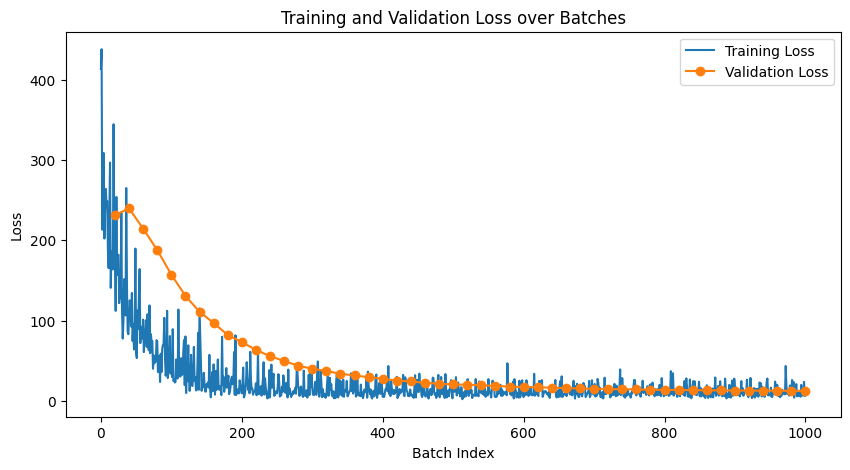

In [9]:
model = HouseLinearRegression(13, lr=0.01)
data = BostonHouseData(20)
trainer = HouseLRTrainer(max_epochs=50)
trainer.fit(model, data)

### Training and Validation Loss Analysis

The plot above shows the training and validation loss over batches for our linear regression model on the Boston Housing dataset. Key observations include:

* **Training Loss Behavior**: The training loss (blue line) decreases rapidly in the early batches, indicating that the model quickly learns basic patterns in the data. After around batch 200–300, the curve begins to flatten, suggesting the model is approaching convergence.

* **Validation Loss Behavior**: The validation loss (orange line, averaged per epoch) follows a similar downward trend, confirming that the model is generalizing well to unseen data and not overfitting in the early stages.

* **Loss Magnitude and Convergence**: Both training and validation losses eventually stabilize around a lower value, demonstrating effective optimization. The small fluctuations in training loss are typical due to stochastic batch updates.

* **Model Performance Insight**: The alignment of training and validation loss curves indicates that the model has achieved a good balance between learning the training data and generalizing to validation data. The absence of divergence between the curves suggests minimal overfitting.

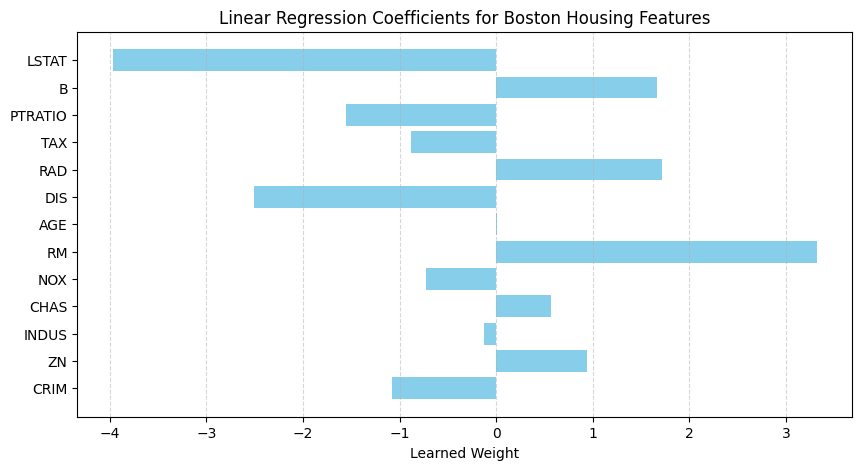

In [10]:
weights = model.w.detach().numpy().flatten()
features = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"]

plt.figure(figsize=(10,5))
plt.barh(features, weights, color='skyblue')
plt.xlabel("Learned Weight")
plt.title("Linear Regression Coefficients for Boston Housing Features")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.show()

### Interpretation of Learned Weights

The histogram above shows the final weights learned by the linear regression model for each feature in the Boston Housing dataset. A few key points can be made in relation to the initial scatterplots:

- Sign of Weights: Positive weights indicate features that increase the predicted house price, while negative weights indicate features that decrease it. For example:
    * RM (average number of rooms per dwelling) had a strong positive correlation in the scatterplot, which aligns with the positive weight 3.2893963.
	* LSTAT (% lower status population) had a negative correlation with price in the scatterplot, matching the large negative weight -3.9487.
- Magnitude of Weights: Features with larger absolute weights have a stronger impact on the predicted price. This aligns with the scatterplots where the relationship between the feature and the target is steep or more pronounced. For instance:
	* DIS (distance to employment centers) has a negative weight -2.5125, reflecting its importance in reducing predicted price for farther distances.
	* RM and LSTAT dominate the price predictions, consistent with their strong trends in the scatterplots.
- Smaller Weights: Features with weights near zero, such as AGE (0.02582791), indicate little influence on the target, matching scatterplots where the relationship is nearly flat or weak.

#### Connection to Scatterplots:

By comparing the learned weights with the initial scatterplots, we can see that the model has successfully captured the direction and relative importance of each feature. Features that showed strong positive or negative correlations in the plots correspond to larger magnitude weights, confirming that the model aligns with the underlying data trends observed visually.

### References

* Zhang, A., Lipton, Z. C., Li, M., & Smola, A. J. *Dive into Deep Learning*. [https://d2l.ai](https://d2l.ai)